# Quora Question Pairs - Kaggle Prediction Competition

Running the Quora Question Pairs Prediction Competition. Details can be found at: https://www.kaggle.com/c/quora-question-pairs

## Importing Data

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function, division
%matplotlib inline

pal = sns.color_palette()

# Input data files are available in the "input/" directory.
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

print(train_df.shape)
print(test_df.shape)

sample_submission.csv
sample_submission.csv.zip
test.csv
test.csv.zip
train.csv
train.csv.zip

(404290, 6)
(2345796, 3)


View the first 10 records from each of **train_df** and **test_df**.

In [2]:
print("Train Dataframe first 5 records: ")
train_df.head()

Train Dataframe first 5 records: 


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print("Test Dataframe first 5 records: ")
test_df.head()

Test Dataframe first 5 records: 


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


## Data Analysis
### Initial Review of Dataset
The following code displays the number and percentage of duplicate records in the training dataset.

In [4]:
is_dup = train_df['is_duplicate'].value_counts()

print("Number of Duplicate Records in Training Dataset: ")
print(is_dup)

print("\nPercentage of Duplicate Records in Training Dataset: ")
print(is_dup / is_dup.sum())

Number of Duplicate Records in Training Dataset: 
0    255027
1    149263
Name: is_duplicate, dtype: int64

Percentage of Duplicate Records in Training Dataset: 
0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64


### Identifying Duplicate Questions

Total number of question pairs in the training set: 404290
Duplicate pairs: 36.92%
Total number of unique questions (across both qid1 and qid2) in the training data: 537933
Number of Questions that Appear Multiple Times: 111780



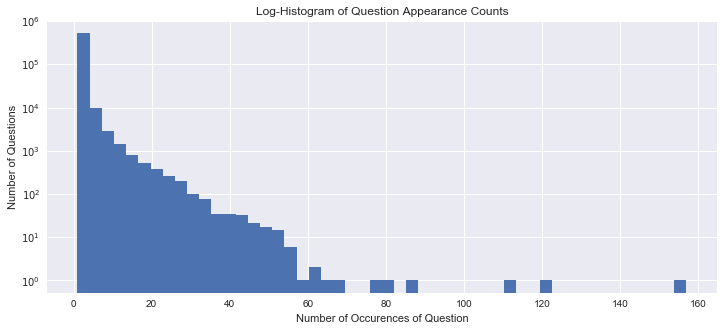

In [5]:
###
# Note: The following notebook was referenced when preparing the approach to data analysis activities below:
# https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
###

print("Total number of question pairs in the training set: {}".format(len(train_df)))
print('Duplicate pairs: {}%'.format(round(train_df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
#print qids
print('Total number of unique questions (across both qid1 and qid2) in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of Questions that Appear Multiple Times: {}'.format(np.sum(qids.value_counts() > 1)))

#print(qids.value_counts())

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')
print()

**The vast majority of questions either appear once or a few times.** It's possible Quora could have provided every possible unique combination of question (each question compared to every other question) but that would have generated a huge amount of data, and it would be very clear in the majority of cases that questions were not duplicates.

**There is a very small number of questions appearing up to around ~50 times, and three questions that appear over 100 times (111, 120, and 157 times each).** These three questions appear to be outliers.

### Character & Word Counts
Reviewing the character and word counts within questions across both the Training and Test datasets.

In [6]:
train_q = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist()).astype(str)
test_q = pd.Series(test_df['question1'].tolist() + test_df['question2'].tolist()).astype(str)

char_len_train = train_q.apply(len)
word_len_train = train_q.str.split().apply(len)
#print(char_len_train.head())
#print(word_len_train.head())

char_len_test = test_q.apply(len)
word_len_test = test_q.str.split().apply(len)
#print(char_len_test.head())
#print(word_len_test.head())


Character Count Training Set Analysis
count    808580.000000
mean         59.860050
std          31.988383
min           1.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
dtype: float64

Character Count Testing Set Analysis
count    4.691592e+06
mean     6.010517e+01
std      3.165537e+01
min      1.000000e+00
25%      4.000000e+01
50%      5.300000e+01
75%      7.200000e+01
max      1.176000e+03
dtype: float64

Word Count Training Set Analysis
count    808580.000000
mean         11.062100
std           5.884595
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

Word Count Testing Set Analysis
count    4.691592e+06
mean     1.101827e+01
std      5.846748e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      2.380000e+02
dtype: float64


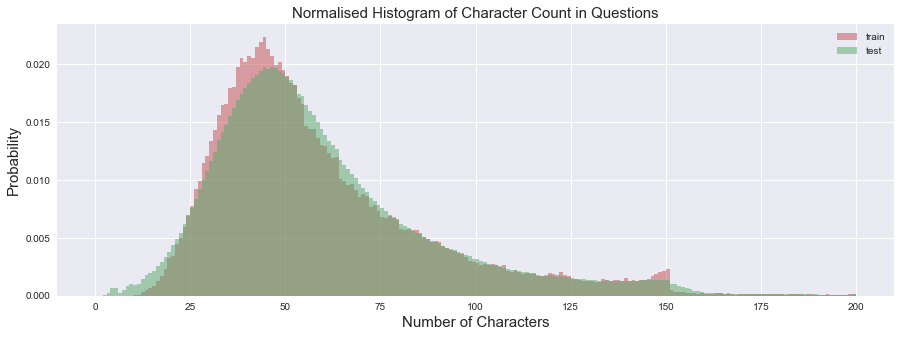

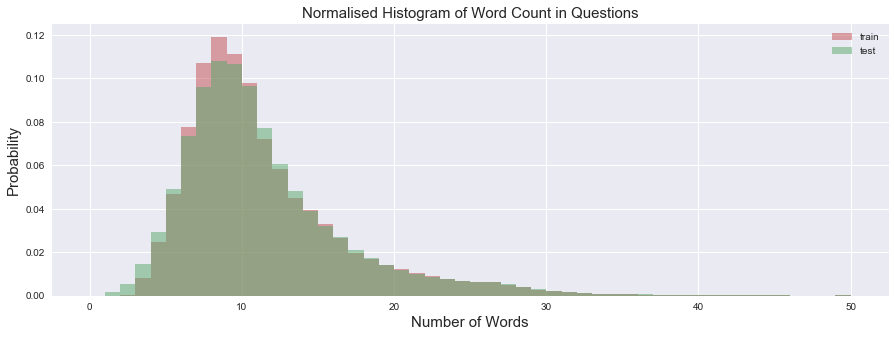

In [7]:
plt.figure(figsize=(15, 5))
plt.hist(char_len_train, bins=200, range=[0, 200], color=pal[2], normed=True, alpha=0.5, label='train')
plt.hist(char_len_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised Histogram of Character Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of Characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

plt.figure(figsize=(15, 5))
plt.hist(word_len_train, bins=50, range=[0, 50], color=pal[2], normed=True, alpha=0.5, label='train')
plt.hist(word_len_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised Histogram of Word Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of Words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print("Character Count Training Set Analysis")
print(char_len_train.describe())

print("\nCharacter Count Testing Set Analysis")
print(char_len_test.describe())

print("\nWord Count Training Set Analysis")
print(word_len_train.describe())

print("\nWord Count Testing Set Analysis")
print(word_len_test.describe())

#print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
#                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

## Feature Analysis
### Stop Words
This Stop Words section was adapted from a benchmark model provided in one of the example Kernels provided. We've removed stopwords from the NLTK corpus and compared the remaining words in common from Question 1 with Question 2 and how this relates to whether the questions are duplicate or not.

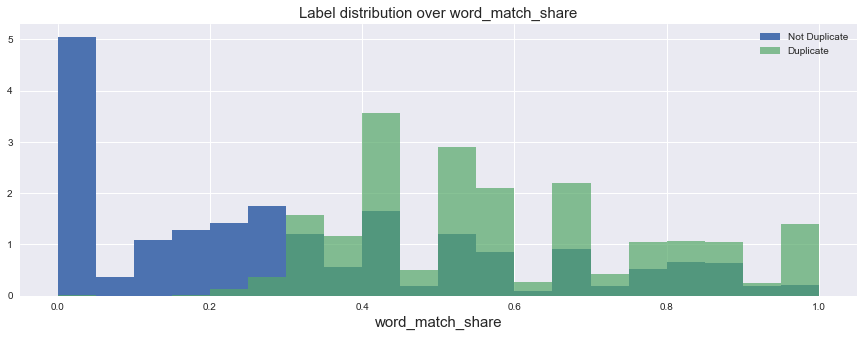

In [8]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float((len(shared_words_in_q1) + len(shared_words_in_q2)))/float((len(q1words) + len(q2words)))
    return R

plt.figure(figsize=(15, 5))
train_word_match = train_df.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[train_df['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[train_df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

From this Distribution chart we can see that the remaining shared words does have a certain amount of predictive power in terms of whether two questions are duplicate or not. In particular, those question pairs with a score of less than .2 in this word share distribution are all Not Duplicates.  However it's not so great at picking out the Duplicates; for those Question Pairs above .4 we see that there are approximately twice as many Duplicate question pairs as compared to Not Duplicates yet we still see some substantial overlap.

Now just for fun, I'm going to take a look at Word Match Share using the stop words from SKLearn Feature Extraction (which contains 318 stop words vs the 153 in the NLTK corpus). It'd be interesting to compare which does a better job overall.

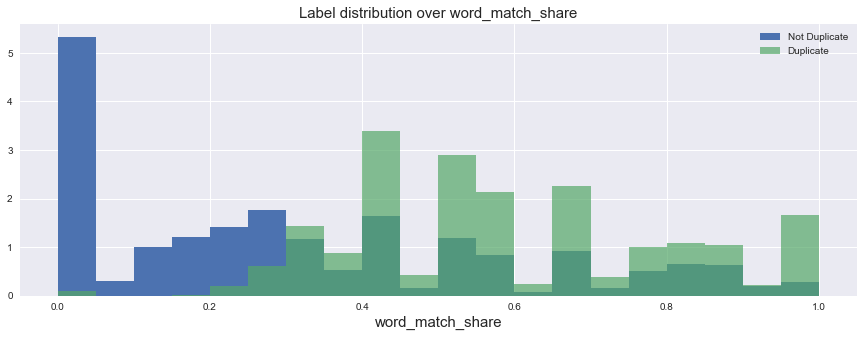

In [9]:
from sklearn.feature_extraction import stop_words

stops_sklearn = set(stop_words.ENGLISH_STOP_WORDS)

def word_match_share_sklearn(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops_sklearn:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops_sklearn:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float((len(shared_words_in_q1) + len(shared_words_in_q2)))/float((len(q1words) + len(q2words)))
    return R

plt.figure(figsize=(15, 5))
train_word_match = train_df.apply(word_match_share_sklearn, axis=1, raw=True)
plt.hist(train_word_match[train_df['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[train_df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

We could create our own stop word list based on frequency in our training set (and test set).  Here's an explanation about dropping common terms, or stop words: https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html

*Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words . The general strategy for determining a stop list is to sort the terms by collection frequency (the total number of times each term appears in the document collection), and then to take the most frequent terms, often hand-filtered for their semantic content relative to the domain of the documents being indexed, as a stop list , the members of which are then discarded during indexing.*

### TF-IDF
Let's test out TF-IDF (Term Frequency - Inverse Document Frequency) which allows us to weigh the terms by how uncommon they are. This puts value on rare words that exist in both questions as opposed to common words.

First, we'll clean up our training questions by removing stop words and punctuation.
#### Remove Punctuation

In [10]:
import string
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

train_q_clean = train_q.apply(remove_punctuation)

#### Remove Stop Words

In [11]:
train_q_split = train_q_clean.str.split()
train_q_nostop = train_q_split.apply(lambda x: [item for item in x if item not in stops_sklearn])
train_q_nostop = train_q_nostop.str.join(' ')

In [27]:
# Select rows for testing 
train_q_nostop_test = train_q_nostop[:100]

#### Get Term Frequency

In [44]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=1):
    if count < min_count:
        return 0
    else:
        return count

eps = 5000 
words = (" ".join(train_q_nostop_test)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

#### Increment Document Counts

In [37]:
#If a word appears in a question, increment the document counts.

doc_count = weights 
for key, value in doc_count.items():
    doc_count[key] = 0 
    
for row in train_q_nostop_test.iteritems():
    for key, value in doc_count.iteritems():
        if key in str(row[1]).lower().split():
            #print("key: ", key, "Row: ", row[1])
            doc_count[key] = doc_count[key] + 1

#### Calculate TF-IDF

In [41]:
def get_tfidf(count, word, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return ((count / len(words)) / np.log(len(train_q_nostop[:100])/doc_count[word]))

eps = 5000 
#words = (" ".join(train_q_nostop_test)).lower().split()
#counts = Counter(words)
tfidf_vals = {word: get_tfidf(count, word) for word, count in counts.items()}

In [46]:
print(len(words))
print(sum(doc_count.values()))
#print(doc_count)
print(len(train_q_nostop[:100]))
print(weights['what'])
print(doc_count['what'])
print(weights['cap'])
print(doc_count['cap'])


655
630
100
44
43
2
1


In [43]:
print('Most common words and weights: \n')
print(sorted(tfidf_vals.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(tfidf_vals.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('cap', 0.00066304501053931575), ('states', 0.00066304501053931575), ('united', 0.00066304501053931575), ('breaking', 0.00066304501053931575), ('product', 0.00066304501053931575), ('data', 0.00066304501053931575), ('effects', 0.00066304501053931575), ('programming', 0.00066304501053931575), ('kohinoor', 0.00066304501053931575), ('potter', 0.00066304501053931575)]

Least common words and weights: 


[('what', 0.079594733135075535),
 ('i', 0.031937523805938887),
 ('how', 0.023892684191730792),
 ('why', 0.0076084283971235046),
 ('best', 0.0057062991646891882),
 ('does', 0.0057062991646891882),
 ('make', 0.0032559431472062449),
 ('learn', 0.0018972059070522498),
 ('mean', 0.0018972059070522498),
 ('good', 0.0018972059070522498)]

In [213]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [ ]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = train_df.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [214]:
print(len(words))

5286965
